<a href="https://colab.research.google.com/github/Vinit-1996/Vectorized-Backtesting/blob/main/Vectorized_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import matplotlib as mpl
from matplotlib import cycler
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## **Sortino Beta Alpha**

The Sortino ratio is a statistic similar to the sharpe ratio with the same interpretation. However the calculation is slightly different. Indeed, in the sortino ratio we only take into the account the volatility of the negative gains because that is what we fear and not the bullish gains that make us earn money.

Sortino = mu/std(down)



*   SortinoRatio <0 : Not profitable investment because you gain in -ve
*   SortinoRatio <1: Profitable Investment but the risk is higher than the return
*   SortinoRatio>1: Very Good Investment because the risk is lower than the return






In [5]:
data= yf.download("RELIANCE.NS", end="2021-01-01")
return_data=data["Adj Close"].pct_change(1)
return_data.name="return"

[*********************100%***********************]  1 of 1 completed


In [6]:
return_data

Date
1996-01-01         NaN
1996-01-02   -0.007776
1996-01-03    0.007593
1996-01-04   -0.009237
1996-01-05   -0.006869
                ...   
2020-12-24    0.025877
2020-12-28    0.004588
2020-12-29   -0.006614
2020-12-30    0.002739
2020-12-31   -0.005111
Name: return, Length: 6287, dtype: float64

In [7]:
#Computer Sortino
vol= return_data[return_data<0].std()
mean=return_data.mean()
sortino=np.sqrt(252)*mean/vol

print(f"Sortino : {np.round(sortino,3)}")

Sortino : 1.011


## BETA

The beta is a statistics that indicates the relationship between the variations of our portfolio and those of the market which is represented by an index.

In [12]:
nifty= yf.download("^NSEI")["Adj Close"].pct_change(1)
nifty.name="nifty"
val = pd.concat((return_data, nifty),axis=1).dropna()
val

[*********************100%***********************]  1 of 1 completed


,return,nifty
Date,,
2007-09-18,0.014667,0.011469
2007-09-19,0.056291,0.040946
2007-09-20,0.007544,0.003212
2007-09-21,0.041159,0.018957
2007-09-24,0.032910,0.019566
...,...,...
2020-12-24,0.025877,0.010893
2020-12-28,0.004588,0.009015
2020-12-29,-0.006614,0.004282


In [16]:
covariance=np.cov(val[["return","nifty"]].values, rowvar=False)[0][1]

In [17]:
var =np.var(val['nifty'].values)

In [18]:
beta=covariance/var

In [20]:
print(f"Beta is {np.round(beta,3)} ")

Beta is 1.147 


## Alpha

Alpha is a statistic that indicates whether the portfolio outperforms the market in terms of risk return.

In [22]:
mean= return_data.mean()
alpha= 252 * (mean - beta*mean)
print(f" Alpha {np.round(alpha,3)}")

 Alpha -0.046


## **DRAWDOWN**

The drawdown is a measure of the risk of the strategy. An interesting statistic to know the performance of the algorithm is the maximum drawdown. Indeed, it represents the maximum loss of a strategy over a period of time which allows you to understand if the strategy is risky and thus choose it according to your level of risk aversion. 

In [23]:
def drawdown_function(series):
  cum= series.dropna().cumsum() + 1
  running_max = np.maximum.accumulate(cum)
  drawdown= cum/running_max -1
  return drawdown

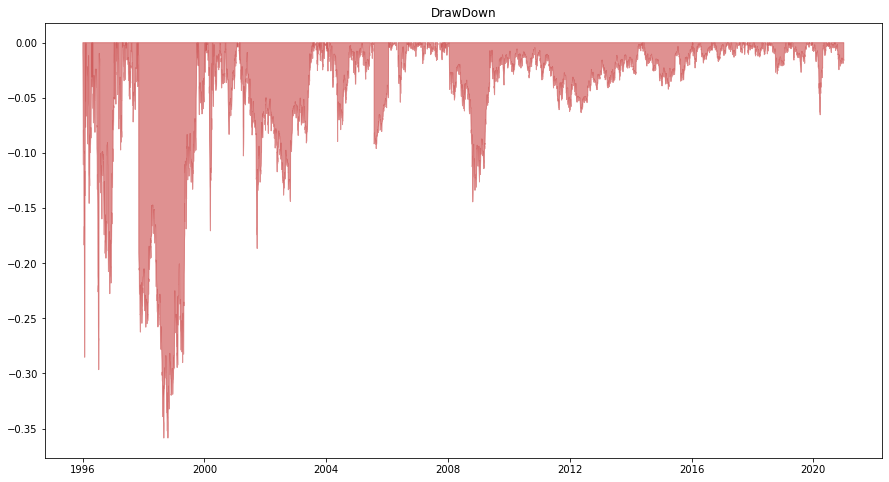

In [24]:
drawdown=drawdown_function(return_data)

plt.figure(figsize=(15,8))
plt.fill_between(drawdown.index, drawdown, 0 , drawdown<0, color="#CE5757",alpha=0.65)
plt.title("DrawDown")
plt.show()

In [26]:
max_drawdown = -np.min(drawdown) *100
print(f" Max Drawdown is {np.round(max_drawdown,1)}")

 Max Drawdown is 35.9


## **Creating function Backtest to evaluate the strategy**

In [47]:
def Backtest(serie):
  #Import the benchmark
  nifty= yf.download("^NSEI")["Adj Close"].pct_change(1)
  #Change the name
  nifty.name="nifty"
  #Concat the returns and the nifty
  val = pd.concat((return_data, nifty),axis=1).dropna()
  #Compute the drawdown
  drawdown=drawdown_function(serie)
  #Compute max drawdown
  max_drawdown = -np.min(drawdown) *100
  #Put a subplots
  fig, (cum,dra)=plt.subplots(1,2,figsize=(20,6))
  #Put a subtitle
  #fig.subtitle("Backtesting", size=20)
  #Return cumsum chart
  cum.plot(serie.cumsum(),color="#39B3C7")
  #Nifty cumsum chart
  cum.plot(val["nifty"].cumsum(),color="#B85A0F")
  #Put a legend
  plt.legend(["Portfolio","BenchMark"])
  #Set Individual title
  dra.set_title("Cumulative Returns",size=13)
  #Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown*100, color="#C73954",alpha=0.65)
  #Set Individual title
  dra.set_title("Drawdown",size=13)
  dra.set_ylabel("Drawdown %")
  #Plot the graph
  plt.show()

  ''' Create the metrics '''

  #Computer the sortino
  sortino=np.sqrt(252) * serie.mean() / serie.loc[serie<0].std()

  #Compute the beta
  beta=np.cov(val[["return","nifty"]].values,rowvar=False)[0][1]/np.var(val["nifty"].values)

  #Compute the alpha
  alpha= 252 * (serie.mean() - beta * serie.mean())

  #Print the statistics
  print(f" Sortino : {np.round(sortino,3)}")
  print(f" Beta : {np.round(beta,3)}")
  print(f" Alpha : {np.round(alpha,3)} % ")
  print(f" Max Drawdown {np.round(max_drawdown,1)} % ")

[*********************100%***********************]  1 of 1 completed


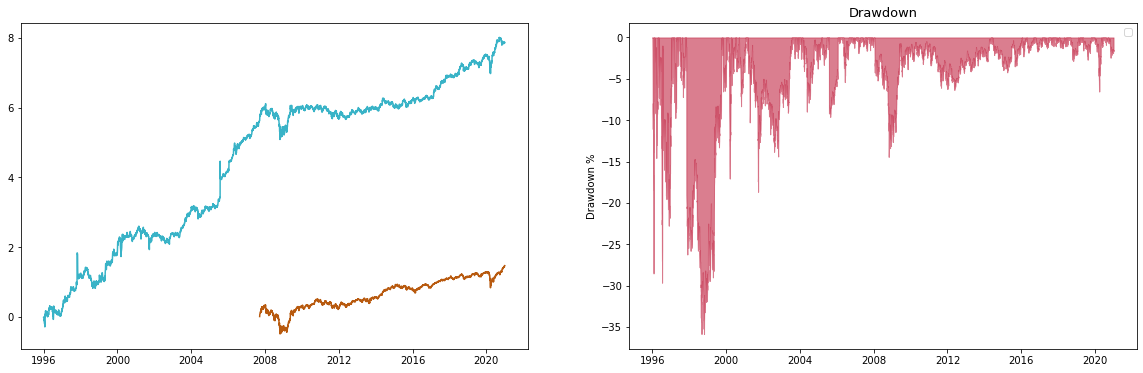

 Sortino : 1.011
 Beta : 1.147
 Alpha : -0.046 % 
 Max Drawdown 35.9 % 


In [48]:
Backtest(return_data)